<a href="https://colab.research.google.com/github/sarmishtahari/DS/blob/master/15-07-2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **Inroduction**:


Aiming to minimize police response time by detecting weapons in a live cctv camera. The main motivation of this project is due to the increasing number of school mass shootings in the U.S.


### This notebook is a part of this [medium post](https://medium.com/@alaasinjab/detailed-tutorial-build-your-custom-real-time-object-detector-5ade1017fd2d).

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### This notebook was designed to be ran from top to bottom without the need to mount Google Drive

## Weapon Detection Using Tensorflow Object Detection API

Workspace structure

```
gun_detection/
        ├─ data/
        │    ├── images/
        │    │      ├── armas (1).jpg
        │    │      ├── armas (2).jpg
        │    │      └── ...
        │    ├── train_labels/
        │    │      ├── armas (1).xml
        │    │      ├── armas (2).xml
        │    │      └── ...
        │    ├── test_labels/
        │    │      ├── armas (10).xml
        │    │      ├── armas (20).xml
        │    │      └── ...
        │    ├── label_map.pbtxt
        │    ├── test_labels.csv
        │    ├── train_labels.csv
        │    ├── test_labels.record
        │    └── train_labels.record
        └─ models/
             ├─ research/
             │      ├── fine_tuned_model/
             │      │         ├── frozen_inference_graph.pb
             │      │         └── ...
             │      │         
             │      ├── pretrained_model/
             │      │         ├── frozen_inference_graph.pb
             │      │         └── ...
             │      │         
             │      ├── object_detection/
             │      │         ├── utils/
             │      │         ├── samples/
             │      │         │      ├── samples/ 
             │      │         │      │       ├── configs/             
             │      │         │      │       │     ├── ssd_mobilenet_v2_coco.config
             │      │         │      │       │     ├── rfcn_resnet101_pets.config
             │      │         │      │       │     └── ...
             │      │         │      │       └── ... 
             │      │         │      └── ...                                
             │      │         ├── export_inference_graph.py
             │      │         ├── model_main.py
             │      │         └── ...
             │      │         
             │      ├── training/
             │      │         ├── events.out.tfevents.xxxxx
             │      │         └── ...               
             │      └── ...
             └── ...




## Choosing a pre training model
The model used for this project is `ssd_mobilenet_v2_coco`.
Check other models from [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models).

Because the interestes of this project is to interfere on real time video, i am chosing a model that has a high inference speed `(ms)` with relativly high `mAP` on COCO

In [ ]:


# Some models to train on
MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
    }
}

# Select a model in `MODELS_CONFIG`.
# I chose ssd_mobilenet_v2 for this project, you could choose any
selected_model = 'ssd_mobilenet_v2'


## Installing Required Packages 

In [ ]:
!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -qq Cython contextlib2 pillow lxml matplotlib

!pip install -qq pycocotools

Selecting previously unselected package python-bs4.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../0-python-bs4_4.6.0-1_all.deb ...
Unpacking python-bs4 (4.6.0-1) ...
Selecting previously unselected package python-pkg-resources.
Preparing to unpack .../1-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-chardet.
Preparing to unpack .../2-python-chardet_3.0.4-1_all.deb ...
Unpacking python-chardet (3.0.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-webencodings.
Preparing to unpack .../4-python-webencodings_0.5-2_all.deb ...
Unpacking python-webencodings (0.5-2) ...
Selecting previously unselected package python-html5lib.
Preparing to unpack .../5-python-html5lib_0.999999999-1_all.deb ...
Unpacking pyt

## General imports
Other Imports will be done after downloading some packages later.

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv
import re
import cv2 
import os
import glob
import xml.etree.ElementTree as ET

import io
import tensorflow.compat.v1 as tf

from PIL import Image
from collections import namedtuple, OrderedDict

import shutil
import urllib.request
import tarfile

from google.colab import files

In [ ]:
#we need tenorflow v 1.15.0, object detection API is removed from tf v 2.0+
#!pip install tensorflow==1.15.0

print(tf.__version__)

1.15.2


## Downloading and Orgniazing Images and Annotations
1. Downloading the images and annotations from the [source](https://sci2s.ugr.es/weapons-detection)  and unziping them
2. Creating a directory `(data)` to save some data such as; images, annotation, csv, etc...
3. Creating two directories; for the training and testing labels (not the images)
4. Randomly splitting our labels into 80% training and 20% testing and moving the splits to their directories: `(train_labels)` & `(test_labels)` 

In [ ]:
#creates a directory for the whole project
!mkdir gun_detection

In [ ]:
cd gun_detection

/content/gun_detection


In [ ]:
#Training images and annotations

#Source: https://sci2s.ugr.es/weapons-detection


#download the images zip
!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS.zip

#unzip the image file
!unzip -q WeaponS.zip

#download the annotations zip
!wget https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS_bbox.zip

#unzip the annotations file
!unzip -q WeaponS_bbox.zip

--2020-07-16 02:04:35--  https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250005059 (238M) [application/zip]
Saving to: ‘WeaponS.zip’

WeaponS.zip         100%[===================>] 238.42M  9.18MB/s    in 28s     

2020-07-16 02:05:04 (8.54 MB/s) - ‘WeaponS.zip’ saved [250005059/250005059]

--2020-07-16 02:05:11--  https://sci2s.ugr.es/sites/default/files/files/TematicWebSites/WeaponsDetection/BasesDeDatos/WeaponS_bbox.zip
Resolving sci2s.ugr.es (sci2s.ugr.es)... 150.214.190.154
Connecting to sci2s.ugr.es (sci2s.ugr.es)|150.214.190.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1420022 (1.4M) [application/zip]
Saving to: ‘WeaponS_bbox.zip’

WeaponS_bbox.zip    100%[===================>]   1.35M   804KB/s    in 1.7

In [ ]:
# creating a directory to store the training and testing data
!mkdir data

# folders for the training and testing data.
!mkdir data/images data/train_labels data/test_labels


# combining the images and annotation in the training folder:
# moves the images to data folder
!mv WeaponS/* data/images

# moves the annotations to data folder
!mv WeaponS_bbox/* data/train_labels

In [ ]:
import os
os.listdir('data')

['test_labels', 'images', 'train_labels']

In [ ]:
# Deleting the zipped and unzipped folders 
!rm -rf WeaponS_bbox.zip  WeaponS.zip WeaponS/  WeaponS_bbox/

In [ ]:

# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 600 labels to the testing dir: `test_labels`
!ls data/train_labels/* | sort -R | head -600 | xargs -I{} mv {} data/test_labels

In [ ]:
# 2400 "images"(xml) for training
!ls data/train_labels/ | wc -l

2400


In [ ]:
# 600 "images"(xml) for testing
!ls  data/test_labels/ | wc -l

600


## Preprocessing Images and Labels
1. Converting the annotations from xml files to two csv files for each `train_labels/` and `train_labels/`.
2. Creating a pbtxt file that specifies the number of class (one class in this case)
3. Checking if the annotations for each object are placed within the range of the image width and height.

In [ ]:

#adjusted from: https://github.com/datitran/raccoon_dataset

#converts the annotations/labels into one csv file for each training and testing labels
#creats label_map.pbtxt file

%cd /content/gun_detection/data


# images extension
images_extension = 'jpg'

# takes the path of a directory that contains xml files and converts
#  them to one csv file.

# returns a csv file that contains: image name, width, height, class, xmin, ymin, xmax, ymax.
# note: if the xml file contains more than one box/label, it will create more than one row for the same image. each row contains the info for an individual box. 
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text + '.' + images_extension,
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

# for both the train_labels and test_labels csv files, it runs the xml_to_csv() above.
for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

# Creating the `label_map.pbtxt` file
label_map_path = os.path.join("label_map.pbtxt")

pbtxt_content = ""

#creats a pbtxt file the has the class names.
for i, class_name in enumerate(classes):
    # display_name is optional.
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n    display_name: 'Gun'\n }}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)


/content/gun_detection/data
Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.


In [ ]:
import pandas as pd
#print(os.listdir("data"))
train = pd.read_csv("train_labels.csv")
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,armas (1453).jpg,500,333,pistol,29,43,498,243
1,armas (2008).jpg,600,343,pistol,14,127,197,275
2,armas (824).jpg,300,225,pistol,11,35,288,198
3,armas (1337).jpg,1024,683,pistol,179,134,867,543
4,armas (2970).jpg,434,569,pistol,224,86,409,270


In [ ]:
#checking the pbtxt file
!cat label_map.pbtxt

item {
    id: 1
    name: 'pistol'
    display_name: 'Gun'
 }

In [ ]:
# they are there!
!ls -l

total 416
drwxr-xr-x 2 root root 122880 Jul 16 02:05 images
-rw-r--r-- 1 root root     62 Jul 16 02:05 label_map.pbtxt
drwxr-xr-x 2 root root  20480 Jul 16 02:05 test_labels
-rw-r--r-- 1 root root  31658 Jul 16 02:05 test_labels.csv
drwxr-xr-x 2 root root 114688 Jul 16 02:05 train_labels
-rw-r--r-- 1 root root 128263 Jul 16 02:05 train_labels.csv


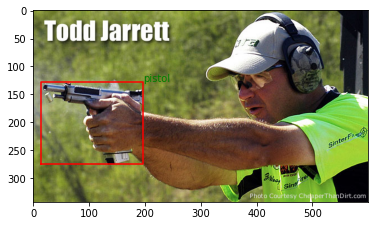

In [ ]:
## Display few images with box and label
import matplotlib.pyplot as plt
import matplotlib.patches as patches
for row in train.values[1:]:
  img = plt.imread("images/"+row[0])
  plt.imshow(img)
  plt.plot([row[4],row[6],row[6],row[4],row[4]],[row[7],row[7],row[5],row[5],row[7]],color='r')
  plt.text(row[6],row[5],row[3],color='g')
  break

In [ ]:
#checks if the images box position is placed within the image.

#note: while this doesn't checks if the boxes/annotatoins are correctly
# placed around the object, Tensorflow will through an error if this occured.
%cd /content/gun_detection/data
# path to images
images_path = 'images'

#loops over both train_labels and test_labels csv files to do the check
# returns the image name where an error is found 
# return the incorrect attributes; xmin, ymin, xmax, ymax.
for CSV_FILE in ['train_labels.csv', 'test_labels.csv']:
  with open(CSV_FILE, 'r') as fid:  
      print('[*] Checking file:', CSV_FILE) 
      file = csv.reader(fid, delimiter=',')
      first = True 
      cnt = 0
      error_cnt = 0
      error = False
      for row in file:
          if error == True:
              error_cnt += 1
              error = False         
          if first == True:
              first = False
              continue     
          cnt += 1      
          name, width, height, xmin, ymin, xmax, ymax = row[0], int(row[1]), int(row[2]), int(row[4]), int(row[5]), int(row[6]), int(row[7])     
          path = os.path.join(images_path, name)
          img = cv2.imread(path)         
          if type(img) == type(None):
              error = True
              print('Could not read image', img)
              continue     
          org_height, org_width = img.shape[:2]     
          if org_width != width:
              error = True
              print('Width mismatch for image: ', name, width, '!=', org_width)     
          if org_height != height:
              error = True
              print('Height mismatch for image: ', name, height, '!=', org_height) 
          if xmin > org_width:
              error = True
              print('XMIN > org_width for file', name)  
          if xmax > org_width:
              error = True
              print('XMAX > org_width for file', name)
          if ymin > org_height:
              error = True
              print('YMIN > org_height for file', name)
          if ymax > org_height:
              error = True
              print('YMAX > org_height for file', name)
          if error == True:
              print('Error for file: %s' % name)
              print()
      print()
      print('Checked %d files and realized %d errors' % (cnt, error_cnt))
      print("-----")

/content/gun_detection/data
[*] Checking file: train_labels.csv
XMIN > org_width for file armas (2815).jpg
XMAX > org_width for file armas (2815).jpg
YMIN > org_height for file armas (2815).jpg
YMAX > org_height for file armas (2815).jpg
Error for file: armas (2815).jpg


Checked 2777 files and realized 1 errors
-----
[*] Checking file: test_labels.csv

Checked 687 files and realized 0 errors
-----


In [ ]:
#we have only one image with incorrect box position, we could just remove it 
#removing the image 
!rm images/'armas (2815).jpg'

In [ ]:
#removing the entry for it in the csv for that image as well

#because we did a random split for the data, we dont know if it ended up being in training or testing
# we will remove the image from both.

#training
#reading the training csv
df = pd.read_csv('/content/gun_detection/data/train_labels.csv')
# removing armas (2815).jpg
df = df[df['filename'] != 'armas (2815).jpg']
#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/gun_detection/data/train_labels.csv')


#testing
#reading the testing csv
df = pd.read_csv('/content/gun_detection/data/test_labels.csv')
# removing armas (2815).jpg
df = df[df['filename'] != 'armas (2815).jpg']
#reseting the index
df.reset_index(drop=True, inplace=True)
#saving the df
df.to_csv('/content/gun_detection/data/test_labels.csv')

# Just for the memory
df = None


## Downloading and Preparing Tensorflow model
1. Cloning [Tensorflow models](https://github.com/tensorflow/models.git) from the offical git repo. The repo contains the object detection API we are interseted in. 
2. Compiling the protos and adding folders to the os environment.
3. Testing the model builder.

In [ ]:
# Downlaods Tenorflow
%cd /content/gun_detection/
!git clone --q https://github.com/tensorflow/models.git

/content/gun_detection


In [ ]:
!mv models/official models/research/official

In [ ]:
%cd /content/gun_detection/models/research
#compiling the proto buffers (not important to understand for this project but you can learn more about them here: https://developers.google.com/protocol-buffers/)
!protoc object_detection/protos/*.proto --python_out=.

# exports the PYTHONPATH environment variable with the reasearch and slim folders' paths
os.environ['PYTHONPATH'] += ':/content/gun_detection/models/research/:/content/gun_detection/models/research/slim/'

/content/gun_detection/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [ ]:
# testing the model builder
!pip install tf_slim

!python3 object_detection/builders/model_builder_test.py

     |████████████████████████████████| 358kB 2.8MB/s 


## Generating Tf record
- Generating two TFRecords files for the training and testing CSVs.
- Tensorflow accepts the data as tfrecords which is a binary file that run fast with low memory usage. Instead of loading the full data into memory, Tenorflow breaks the data into batches using these TFRecords automatically

In [ ]:
#adjusted from: https://github.com/datitran/raccoon_dataset

# converts the csv files for training and testing data to two TFRecords files.
# places the output in the same directory as the input


from object_detection.utils import dataset_util
%cd /content/gun_detection/models/

DATA_BASE_PATH = '/content/gun_detection/data/'
image_dir = DATA_BASE_PATH +'images/'

def class_text_to_int(row_label):
		if row_label == 'pistol':
				return 1
		else:
				None


def split(df, group):
		data = namedtuple('data', ['filename', 'object'])
		gb = df.groupby(group)
		return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
		with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
				encoded_jpg = fid.read()
		encoded_jpg_io = io.BytesIO(encoded_jpg)
		image = Image.open(encoded_jpg_io)
		width, height = image.size

		filename = group.filename.encode('utf8')
		image_format = b'jpg'
		xmins = []
		xmaxs = []
		ymins = []
		ymaxs = []
		classes_text = []
		classes = []

		for index, row in group.object.iterrows():
				xmins.append(row['xmin'] / width)
				xmaxs.append(row['xmax'] / width)
				ymins.append(row['ymin'] / height)
				ymaxs.append(row['ymax'] / height)
				classes_text.append(row['class'].encode('utf8'))
				classes.append(class_text_to_int(row['class']))

		tf_example = tf.train.Example(features=tf.train.Features(feature={
				'image/height': dataset_util.int64_feature(height),
				'image/width': dataset_util.int64_feature(width),
				'image/filename': dataset_util.bytes_feature(filename),
				'image/source_id': dataset_util.bytes_feature(filename),
				'image/encoded': dataset_util.bytes_feature(encoded_jpg),
				'image/format': dataset_util.bytes_feature(image_format),
				'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
				'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
				'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
				'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
				'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
				'image/object/class/label': dataset_util.int64_list_feature(classes),
		}))
		return tf_example

for csv in ['train_labels', 'test_labels']:
  writer = tf.io.TFRecordWriter(DATA_BASE_PATH + csv + '.record')
  path = os.path.join(image_dir)
  examples = pd.read_csv(DATA_BASE_PATH + csv + '.csv')
  grouped = split(examples, 'filename')
  for group in grouped:
      tf_example = create_tf_example(group, path)
      writer.write(tf_example.SerializeToString())
    
  writer.close()
  output_path = os.path.join(os.getcwd(), DATA_BASE_PATH + csv + '.record')
  print('Successfully created the TFRecords: {}'.format(DATA_BASE_PATH +csv + '.record'))


/content/gun_detection/models
Successfully created the TFRecords: /content/gun_detection/data/train_labels.record
Successfully created the TFRecords: /content/gun_detection/data/test_labels.record


In [ ]:
# TFRecords are created
!ls -lX /content/gun_detection/data/

total 252480
drwxr-xr-x 2 root root    122880 Jul 16 02:06 images
drwxr-xr-x 2 root root     20480 Jul 16 02:05 test_labels
drwxr-xr-x 2 root root    114688 Jul 16 02:05 train_labels
-rw-r--r-- 1 root root     34297 Jul 16 02:06 test_labels.csv
-rw-r--r-- 1 root root    140935 Jul 16 02:06 train_labels.csv
-rw-r--r-- 1 root root        62 Jul 16 02:05 label_map.pbtxt
-rw-r--r-- 1 root root  45905348 Jul 16 02:07 test_labels.record
-rw-r--r-- 1 root root 212188806 Jul 16 02:07 train_labels.record


## Downloading the Base Model
1. Based on the model selecting at the top of this notebook, downloading the model selected and extracting its content.
2. Creating a dir to save the model while training.

In [ ]:
%cd /content/gun_detection/models/research

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

#selecting the model
MODEL_FILE = MODEL + '.tar.gz'

#creating the downlaod link for the model selected
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/gun_detection/models/research/pretrained_model'

#checks if the model has already been downloaded
if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#unzipping the file and extracting its content
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

# creating an output file to save the model while training
os.remove(MODEL_FILE)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(MODEL, fine_tune_dir)

/content/gun_detection/models/research


In [ ]:
#checking the content of the pretrained model.
# this is the directory of the "fine_tune_checkpoint" that is used in the config file.
!echo {fine_tune_dir}
!ls -alh {fine_tune_dir}

/content/gun_detection/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 64 root   root  4.0K Jul 16 02:07 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


## Configuring the Training Pipeline
1. Adding the path for the TFRecords files and pbtxt,batch_size,num_steps,num_classes to the configuration file.
2. Adding some Image augmentation.
3. Creating a directory to save the model at each checkpoint while training. 

In [ ]:

#the path to the folder containing all the sample config files
CONFIG_BASE = "/content/gun_detection/models/research/object_detection/samples/configs/"

#path to the specified model's config file
model_pipline = os.path.join(CONFIG_BASE, pipeline_file)
model_pipline

'/content/gun_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config'

In [ ]:


#check the sample config file that is provided by the tf model
!cat /content/gun_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 90
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect

In [ ]:
#editing the configuration file to add the path for the TFRecords files, pbtxt,batch_size,num_steps,num_classes.
# any image augmentation, hyperparemeter tunning (drop out, batch normalization... etc) would be editted here

%%writefile {model_pipline}
model {
  ssd {
    num_classes: 1 # number of classes to be detected
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.3333
      }
    }
    # all images will be resized to the below W x H.
    image_resizer { 
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    box_predictor {
      convolutional_box_predictor {
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        #use_dropout: false
        use_dropout: true # to counter over fitting. you can also try tweaking its probability below
        dropout_keep_probability: 0.8
        kernel_size: 1
        box_code_size: 4
        apply_sigmoid_to_scores: false
        conv_hyperparams {
          activation: RELU_6,
          regularizer {
            l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
          }
          initializer {
            truncated_normal_initializer {
              stddev: 0.03
              mean: 0.0
            }
          }
          batch_norm {
            train: true,
            scale: true,
            center: true,
            decay: 0.9997,
            epsilon: 0.001,
          }
        }
      }
    }
    feature_extractor {
      type: 'ssd_mobilenet_v2'
      min_depth: 16
      depth_multiplier: 1.0
      conv_hyperparams {
        activation: RELU_6,
        regularizer {
          l2_regularizer {
            # weight: 0.00004
            weight: 0.001 # higher regularizition to counter overfitting
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          train: true,
          scale: true,
          center: true,
          decay: 0.9997,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid {
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000 
        iou_threshold: 0.95
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 3
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.6
        
        #adjust this to the max number of objects per class. 
        # ex, in my case, i have one pistol in most of the images.
        # . there are some images with more than one up to 16.
        max_detections_per_class: 16
        # max number of detections among all classes. I have 1 class only so
        max_total_detections: 16
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  batch_size: 16 # training batch size
  optimizer {
    rms_prop_optimizer: {
      learning_rate: {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.003
          decay_steps: 800720
          decay_factor: 0.95
        }
      }
      momentum_optimizer_value: 0.9
      decay: 0.9
      epsilon: 1.0
    }
  }

  #the path to the pretrained model. 
  fine_tune_checkpoint: "/content/gun_detection/models/research/pretrained_model/model.ckpt"
  fine_tune_checkpoint_type:  "detection"
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 2000 
  

  #data augmentaion is done here, you can remove or add more.
  # They will help the model generalize but the training time will increase greatly by using more data augmentation.
  # Check this link to add more image augmentation: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto
  
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    #path to the training TFRecord
    input_path: "/content/gun_detection/data/train_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/gun_detection/data/label_map.pbtxt"
}

eval_config: {
  # the number of images in your "testing" data (was 600 but we removed one above :) )
  num_examples: 599
  # the number of images to disply in Tensorboard while training
  num_visualizations: 20

  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  #max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
      
    #path to the testing TFRecord
    input_path: "/content/gun_detection/data/test_labels.record"
  }
  #path to the label map 
  label_map_path: "/content/gun_detection/data/label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Overwriting /content/gun_detection/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config


In [ ]:
# where the model will be saved at each checkpoint while training 
model_dir = 'training/'

# Optionally: remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Tensorboard
1. Downlaoding and unzipping Tensorboard
2. creating a link to visualize multiple graph while training.


notes: 
  1. Tensorboard will not log any files until the training starts. 
  2. a max of 20 connection per minute is allowed when using ngrok, you will not be able to access tensorboard while the model is logging.

In [ ]:
#downlaoding ngrok to be able to access tensorboard on google colab
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-07-16 02:08:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.236.74.205, 3.229.170.137, 50.16.116.164, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.236.74.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.08MB/s    in 2.2s    

2020-07-16 02:08:03 (6.08 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
#the logs that are created while training 
LOG_DIR = model_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
#The link to tensorboard.
#works after the training starts.

### note: if you didnt get a link as output, rerun this cell and the one above
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://2d4d3eb813a8.ngrok.io


## Training

Finally training the model!


In [ ]:

!python3 /content/gun_detection/models/research/object_detection/model_main.py \
    --pipeline_config_path={model_pipline}\
    --model_dir={model_dir} \
    --alsologtostderr \

W0716 02:08:16.490682 139743152981888 model_lib.py:758] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: None
I0716 02:08:16.490967 139743152981888 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0716 02:08:16.491102 139743152981888 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0716 02:08:16.491278 139743152981888 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0716 02:08:16.491439 139743152981888 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0716 02:08:16.491610 139743152981888 model_lib.py:774] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_t

## Exporting The Trained model



In [ ]:
#the location where the exported model will be saved in.
output_directory = '/content/gun_detection/models/research/fine_tuned_model'

# goes through the model is the training/ dir and gets the last one.
# you could choose a specfic one instead of the last
lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')
last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)

#exports the model specifed and inference graph
!python /content/gun_detection/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={model_pipline} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-2000
Instructions for updating:
Please use `layer.__call__` method instead.
W0716 02:34:17.420743 140088712140672 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0716 02:34:20.095951 140088712140672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0716 02:34:20.146383 140088712140672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0716 02:34:20.304826 140088712140672 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:dept

In [ ]:
#downloads the frozen model that is needed for inference
files.download(output_directory + '/frozen_inference_graph.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#downlaod the label map
files.download(DATA_BASE_PATH + '/label_map.pbtxt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/gun_detection/models/research/fine_tuned_model/model.ckpt.data-00000-of-00001')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.python.platform import gfile
GRAPH_PB_PATH = '/content/gun_detection/models/research/fine_tuned_model/frozen_inference_graph.pb'
with tf.Session() as sess:
   print("load graph")
   with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
       graph_def = tf.GraphDef()
   graph_def.ParseFromString(f.read())
   sess.graph.as_default()
   tf.import_graph_def(graph_def, name='')
   graph_nodes=[n for n in graph_def.node]
   names = []
   for t in graph_nodes:
      names.append(t.name)
   print(names)

load graph
['image_tensor', 'Cast', 'Preprocessor/mul/x', 'Preprocessor/mul', 'Preprocessor/sub/y', 'Preprocessor/sub', 'Preprocessor/map/Shape', 'Preprocessor/map/strided_slice/stack', 'Preprocessor/map/strided_slice/stack_1', 'Preprocessor/map/strided_slice/stack_2', 'Preprocessor/map/strided_slice', 'Preprocessor/map/TensorArray', 'Preprocessor/map/TensorArrayUnstack/Shape', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1', 'Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2', 'Preprocessor/map/TensorArrayUnstack/strided_slice', 'Preprocessor/map/TensorArrayUnstack/range/start', 'Preprocessor/map/TensorArrayUnstack/range/delta', 'Preprocessor/map/TensorArrayUnstack/range', 'Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3', 'Preprocessor/map/Const', 'Preprocessor/map/TensorArray_1', 'Preprocessor/map/TensorArray_2', 'Preprocessor/map/while/iteration_counter', 'Preprocessor/map/whi

load graph


DecodeError: ignored

In [ ]:
import tensorflow as tf

def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph


In [ ]:
gr = load_graph('/content/gun_detection/models/research/fine_tuned_model/frozen_inference_graph.pb')
gr

In [ ]:
for op in gr.get_operations():
        print(op.name)

prefix/image_tensor
prefix/Cast
prefix/Preprocessor/mul/x
prefix/Preprocessor/mul
prefix/Preprocessor/sub/y
prefix/Preprocessor/sub
prefix/Preprocessor/map/Shape
prefix/Preprocessor/map/strided_slice/stack
prefix/Preprocessor/map/strided_slice/stack_1
prefix/Preprocessor/map/strided_slice/stack_2
prefix/Preprocessor/map/strided_slice
prefix/Preprocessor/map/TensorArray
prefix/Preprocessor/map/TensorArrayUnstack/Shape
prefix/Preprocessor/map/TensorArrayUnstack/strided_slice/stack
prefix/Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1
prefix/Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2
prefix/Preprocessor/map/TensorArrayUnstack/strided_slice
prefix/Preprocessor/map/TensorArrayUnstack/range/start
prefix/Preprocessor/map/TensorArrayUnstack/range/delta
prefix/Preprocessor/map/TensorArrayUnstack/range
prefix/Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3
prefix/Preprocessor/map/Const
prefix/Preprocessor/map/TensorArray_1
prefix/Preprocessor